## Get housing data

In [48]:
import pandas as pd
import numpy as np
import os

base_dir = os.getcwd()
data_dir = base_dir + "/housing/"
os.chdir(data_dir)

housing = pd.read_csv("housing.csv", header=0)
os.chdir(base_dir)

## Split data into train and test
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, shuffle=True, random_state=15)
train_set = train_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

In [49]:
print(train_set.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16339 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.3+ MB
None


## Missing value imputation for numeric and categorical features

In [50]:
from sklearn.impute import SimpleImputer

numeric_imputer = SimpleImputer(strategy = "median")
categorical_imputer = SimpleImputer(strategy = "most_frequent")

housing_num = train_set.select_dtypes(include="float64")
housing_cat = train_set.select_dtypes(include="object")

housing_num = pd.DataFrame(numeric_imputer.fit_transform(housing_num), columns=housing_num.columns, index=housing_num.index)
housing_cat = pd.DataFrame(categorical_imputer.fit_transform(housing_cat), columns=housing_cat.columns, index=housing_cat.index)

## One hot encode the categorical feature

In [51]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
onehot_encoded = ohe.fit_transform(housing_cat).toarray()

ohe_column_names = []
for i in ohe.categories_[0]:
  ohe_column_names.append(housing_cat.columns[0] + "_" + i)

onehot_encoded_df = pd.DataFrame(onehot_encoded, index=housing_cat.index, columns=ohe_column_names)

## Calculate new ratios

In [5]:
housing_num["bedrooms_ratio"] = housing_num["total_bedrooms"]/housing_num["total_rooms"]
housing_num["rooms_per_house"] = housing_num["total_rooms"]/housing_num["households"]
housing_num["people_per_house"] = housing_num["population"]/housing_num["households"]

## Calculate cluster similarity

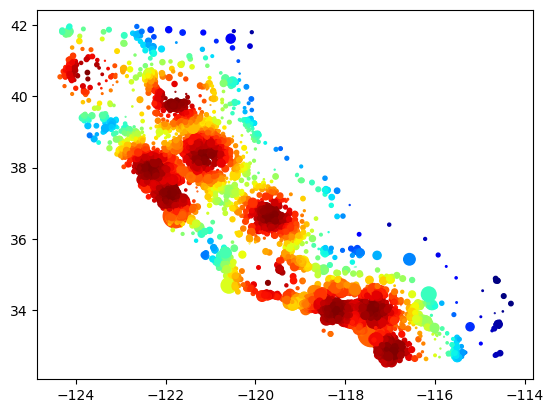

In [6]:
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=10, random_state=10, n_init='auto')
coords = pd.concat([housing_num["longitude"], housing_num["latitude"]], axis=1)
kmeans.fit(coords)

from sklearn.metrics.pairwise import rbf_kernel
cluster_similarities = pd.DataFrame(rbf_kernel(coords, kmeans.cluster_centers_), index=np.arange(0, len(housing_num)))
max_cluster_similarity = cluster_similarities.max(axis=1)

plt.scatter(housing_num["longitude"], housing_num["latitude"], s=housing_num["population"]/100, c=max_cluster_similarity, cmap="jet")
plt.show()

In [7]:
cluster_similarity_column_names = []
for i in range(1, 11):
    column_name = "cluster_" + str(i) + "_similarity"
    cluster_similarity_column_names.append(column_name)
cluster_similarities.columns = cluster_similarity_column_names

## Apply log transform for features with long tail

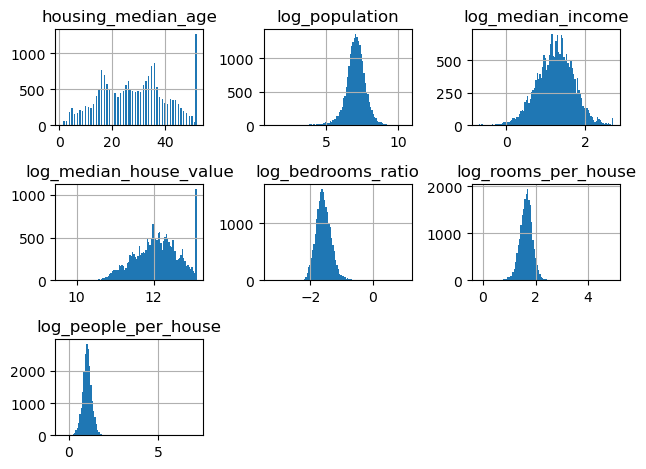

In [42]:
## Drop unwanted columns first
housing_num_sub = housing_num.drop(labels=["longitude", "latitude", "total_rooms", "total_bedrooms", "households"], axis=1)
long_tail_columns = housing_num_sub.columns.tolist()
long_tail_columns.remove("housing_median_age")

long_tail_column_names = []
for i in long_tail_columns:
    long_tail_column_names.append("log_" + i)    

housing_num_sub_log = housing_num_sub[long_tail_columns].apply(np.log)
housing_num_sub_log.columns = long_tail_column_names

housing_num = pd.concat([housing_num_sub["housing_median_age"], housing_num_sub_log], axis=1)
housing_num.hist(bins=100)
plt.tight_layout()
plt.show()

## Standardize numerical features

In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
housing_num_std = scalerhousing_num
print(housing_num_std)

TypeError: StandardScaler.__init__() takes 1 positional argument but 2 were given